In [4]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("TSP Matrix.csv", header=None)
df.columns = ['x', 'y']

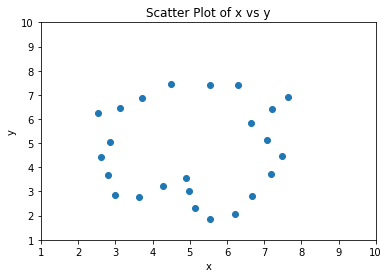

In [6]:
plt.scatter(df['x'], df['y'])
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.title('Scatter Plot of x vs y')
plt.show()

In [7]:
# To calculate the distance between each city
def calculate_distance_matrix(df):
    num_cities = len(df)
    distance_matrix = np.zeros((num_cities, num_cities))

    for i in range(num_cities):
        for j in range(num_cities):
            x1, y1 = df.iloc[i]
            x2, y2 = df.iloc[j]
            distance_matrix[i, j] = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance_matrix

# To run the class to make a matrix
distance_matrix = calculate_distance_matrix(df)

# To display the matrix.
distance_matrix_df = pd.DataFrame(distance_matrix)
distance_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.000000,0.754828,1.344955,2.564838,2.796048,3.327688,4.111249,4.641222,5.098828,5.815422,...,4.386726,3.988462,3.787718,3.295457,2.722923,2.279243,2.098710,1.550642,1.260858,0.873894
1,0.754828,0.000000,0.662256,1.822121,2.109786,2.705419,3.553030,4.205051,4.739405,5.610638,...,4.629071,4.381416,4.311853,3.888250,3.294177,2.753187,2.444147,2.050227,1.961756,1.628650
2,1.344955,0.662256,0.000000,1.250632,1.457410,2.043680,2.901820,3.599568,4.170696,5.130404,...,4.519600,4.418469,4.484554,4.146633,3.543632,2.925453,2.516956,2.293262,2.410979,2.198046
3,2.564838,1.822121,1.250632,0.000000,0.627936,1.349135,2.283698,3.235777,3.931699,5.137388,...,5.288430,5.373747,5.570921,5.303289,4.703334,4.047060,3.578422,3.477723,3.659721,3.433058
4,2.796048,2.109786,1.457410,0.627936,0.000000,0.731248,1.670595,2.607870,3.305480,4.528793,...,4.904377,5.092699,5.385559,5.191958,4.604296,3.921122,3.413939,3.435770,3.750770,3.629253


In [12]:
# Simulated Annealing Evaluation
def evaluate_simulated_annealing(distance_matrix, num_runs, Tmax, Tmin, alpha):
    best_costs = []
    iterations_to_best = []

    def calculate_cost(solution, distance_matrix):
        total_cost = 0
        for i in range(len(solution) - 1):
            total_cost += distance_matrix[solution[i], solution[i+1]]
        total_cost += distance_matrix[solution[-1], solution[0]]
        return total_cost

    def generate_neighbor_swap(solution):
        new_solution = solution.copy()
        i, j = random.sample(range(len(solution)), 2)
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        return new_solution

    def simulated_annealing(distance_matrix, Tmax, Tmin, alpha):
        num_cities = len(distance_matrix)
        current_solution = list(np.random.permutation(num_cities))
        current_cost = calculate_cost(current_solution, distance_matrix)

        best_solution = current_solution.copy()
        best_cost = current_cost
        costs = [current_cost]
        T = Tmax
        iteration = 0
        best_iteration = 0

        while T > Tmin:
            for _ in range(100):
                iteration += 1
                neighbor_solution = generate_neighbor_swap(current_solution)
                neighbor_cost = calculate_cost(neighbor_solution, distance_matrix)
                delta_E = neighbor_cost - current_cost

                if delta_E <= 0 or acceptance_rate < math.exp(-delta_E / T):
                    current_solution = neighbor_solution
                    current_cost = neighbor_cost

                    if current_cost < best_cost:
                        best_solution = current_solution.copy()
                        best_cost = current_cost
                        best_iteration = iteration

            T *= alpha

        return best_cost, best_iteration

    # Run Simulated Annealing multiple times
    for run in range(num_runs):
        best_cost, best_iteration = simulated_annealing(distance_matrix, Tmax, Tmin, alpha)
        best_costs.append(best_cost)
        iterations_to_best.append(best_iteration)

    # Output evaluation
    min_cost = min(best_costs)
    avg_cost = sum(best_costs) / len(best_costs)
    avg_iterations = sum(iterations_to_best) / len(iterations_to_best)

    return min_cost, avg_cost, avg_iterations

In [13]:
# Tabu Search Evaluation
def evaluate_tabu_search(distance_matrix, num_runs, num_iterations, tabu_limit, aspiration):
    best_costs = []
    iterations_to_best = []

    def cost_of_tour(tour, distance_matrix):
        total_cost = 0
        for i in range(len(tour) - 1):
            total_cost += distance_matrix[tour[i], tour[i+1]]
        total_cost += distance_matrix[tour[-1], tour[0]]
        return total_cost

    def generate_initial_solution(num_cities):
        solution = list(range(num_cities))
        random.shuffle(solution)
        return solution

    def get_best_neighbour(tour, distance_matrix, tabu_list, tabu_limit, aspiration):
        best_neighbour = None
        best_neighbour_cost = math.inf

        for i in range(len(tour)):
            for j in range(i + 1, len(tour)):
                new_tour = tour.copy()
                new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
                new_cost = cost_of_tour(new_tour, distance_matrix)

                if tuple(new_tour) in tabu_list:
                    if tabu_list[tuple(new_tour)] > aspiration:
                        continue

                if new_cost < best_neighbour_cost:
                    best_neighbour = new_tour
                    best_neighbour_cost = new_cost
                    tabu_list[tuple(best_neighbour)] = tabu_limit

        return best_neighbour, best_neighbour_cost

    def tabu_search(distance_matrix, num_iterations, tabu_limit, aspiration, max_tabu_size=10):
        num_cities = len(distance_matrix)
        current_solution = generate_initial_solution(num_cities)
        current_cost = cost_of_tour(current_solution, distance_matrix)

        best_solution = current_solution.copy()
        best_cost = current_cost

        tabu_list = {}
        best_iteration = 0

        for iteration in range(num_iterations):
            for tabu in list(tabu_list.keys()):
                tabu_list[tabu] -= 1
                if tabu_list[tabu] <= 0:
                    del tabu_list[tabu]

            new_solution, new_cost = get_best_neighbour(current_solution, distance_matrix, tabu_list, tabu_limit, aspiration)
            current_solution = new_solution
            current_cost = new_cost

            if current_cost < best_cost:
                best_solution = current_solution.copy()
                best_cost = current_cost
                best_iteration = iteration + 1

            if len(tabu_list) > max_tabu_size:
                tabu_list.pop(next(iter(tabu_list)))

        return best_cost, best_iteration

    # Run Tabu Search multiple times
    for run in range(num_runs):
        best_cost, best_iteration = tabu_search(distance_matrix, num_iterations, tabu_limit, aspiration)
        best_costs.append(best_cost)
        iterations_to_best.append(best_iteration)

    # Output evaluation
    min_cost = min(best_costs)
    avg_cost = sum(best_costs) / len(best_costs)
    avg_iterations = sum(iterations_to_best) / len(iterations_to_best)

    return min_cost, avg_cost, avg_iterations

In [14]:
# Simulated Annealing Parameters
Tmax = 10.0
Tmin = 0.0005
alpha = 0.995
num_sa_runs = 10
acceptance_rate = random.uniform(0, 1)

In [15]:
# Tabu Search Parameters
num_ts_iterations = 500
tabu_limit = 5
aspiration = 2
num_ts_runs = 10

In [16]:
# Simulated Annealing Evaluation
sa_min_cost, sa_avg_cost, sa_avg_iterations = evaluate_simulated_annealing(distance_matrix, num_sa_runs, Tmax, Tmin, alpha)

In [17]:
# Tabu Search Evaluation
ts_min_cost, ts_avg_cost, ts_avg_iterations = evaluate_tabu_search(distance_matrix, num_ts_runs, num_ts_iterations, tabu_limit, aspiration)

In [21]:
# Print the results
print(f"1. Simulated Annealing in swapping two adjacent cities:")
print(f"- Maximum temperature: {Tmax}")
print(f"- Minimum temperature: {Tmin}")
print(f"- Alpha(cooling rate): {alpha}")
print(f"- Acceptance rate: {acceptance_rate}")
print(f"- Minimum cost: {sa_min_cost}")
print(f"- Average cost: {sa_avg_cost}")
print(f"- Average iterations to find the best solution: {sa_avg_iterations}")


print(f"2. Tabu Search in swapping two adjacent cities:")
print(f"- Number of iterations: {num_ts_iterations}")
print(f"- Tabu limit: {tabu_limit}")
print(f"- aspiration: {aspiration}")
print(f"- Minimum cost: {ts_min_cost}")
print(f"- Average cost: {ts_avg_cost}")
print(f"- Average iterations to find the best solution: {ts_avg_iterations}")

1. Simulated Annealing in swapping two adjacent cities:
- Maximum temperature: 10.0
- Minimum temperature: 0.0005
- Alpha(cooling rate): 0.995
- Acceptance rate: 0.6332003748998793
- Minimum cost: 19.555012927378094
- Average cost: 19.555012927378097
- Average iterations to find the best solution: 34570.2
2. Tabu Search in swapping two adjacent cities:
- Number of iterations: 500
- Tabu limit: 5
- aspiration: 2
- Minimum cost: 19.555012927378097
- Average cost: 23.76847459879194
- Average iterations to find the best solution: 35.5
